In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
#
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Training RNNs
## Forcasting a Time Series

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
# Create datasets
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, n_steps], series[9000:, -1]

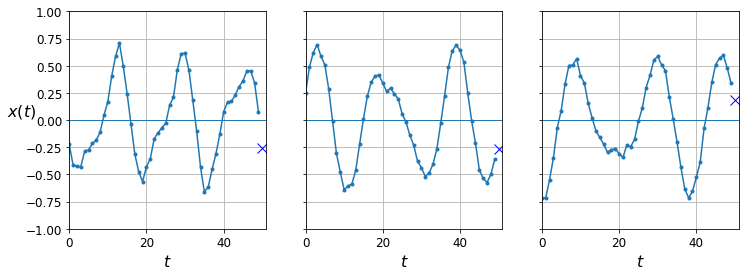

In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

## Baseline Metrics
Naive forcasting

In [5]:
# Naive forcasting
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020548722

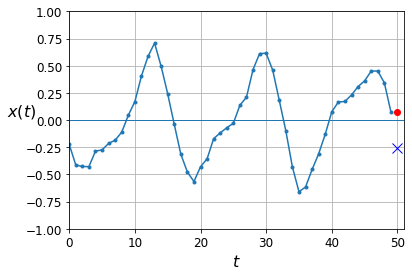

In [6]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Simple linear model (fully connected)

In [7]:
# Fully connected network
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

In [8]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 11ms/step - loss: 0.0579 - val_loss: 0.0228
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0173 - val_loss: 0.0130
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0112 - val_loss: 0.0098
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 7/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 8/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 9/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0047 - val_lo

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0038


0.0037788988556712866

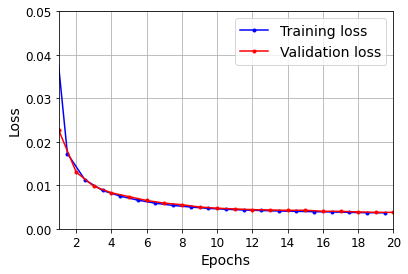

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

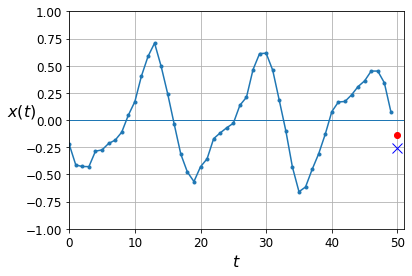

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Implementing a Simple RNN

In [12]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [13]:
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
219/219 [==============================] - 20s 84ms/step - loss: 0.1475 - val_loss: 0.1401
Epoch 2/20
219/219 [==============================] - 18s 84ms/step - loss: 0.0908 - val_loss: 0.0472
Epoch 3/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0361 - val_loss: 0.0288
Epoch 4/20
219/219 [==============================] - 17s 78ms/step - loss: 0.0249 - val_loss: 0.0218
Epoch 5/20
219/219 [==============================] - 21s 95ms/step - loss: 0.0197 - val_loss: 0.0180
Epoch 6/20
219/219 [==============================] - 23s 107ms/step - loss: 0.0167 - val_loss: 0.0156
Epoch 7/20
219/219 [==============================] - 23s 106ms/step - loss: 0.0147 - val_loss: 0.0140
Epoch 8/20
219/219 [==============================] - 24s 110ms/step - loss: 0.0134 - val_loss: 0.0129
Epoch 9/20
219/219 [==============================] - 24s 109ms/step - loss: 0.0125 - val_loss: 0.0122
Epoch 10/20
219/219 [==============================] - 26s 119ms/step - loss: 

In [14]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 4s 70ms/step - loss: 0.0112


0.011204945854842663

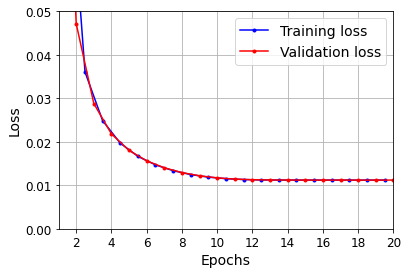

In [15]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

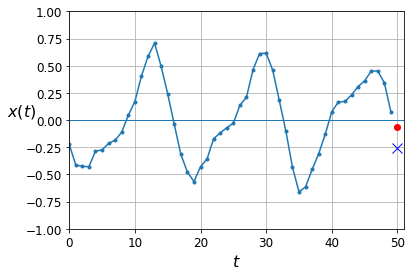

In [16]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# Deep RNNs

In [17]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

In [18]:
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
219/219 [==============================] - 95s 412ms/step - loss: 0.0168 - val_loss: 0.0049
Epoch 2/20
219/219 [==============================] - 82s 376ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 3/20
219/219 [==============================] - 76s 348ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 4/20
219/219 [==============================] - 76s 346ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 5/20
219/219 [==============================] - 69s 316ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 6/20
219/219 [==============================] - 87s 393ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 71s 325ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 8/20
219/219 [==============================] - 70s 318ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 9/20
219/219 [==============================] - 102s 468ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 10/20
219/219 [==============================] - 48s 219ms/step - 

In [19]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 13s 211ms/step - loss: 0.0035


0.0035307775251567364

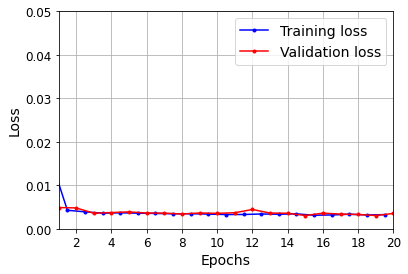

In [20]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

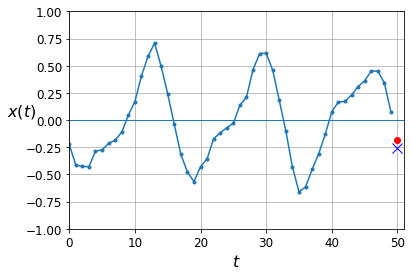

In [21]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [22]:
# Change the last layer to dense (no recurrent)
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

In [23]:
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
219/219 [==============================] - 110s 469ms/step - loss: 0.0114 - val_loss: 0.0036
Epoch 2/20
219/219 [==============================] - 111s 508ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 3/20
219/219 [==============================] - 90s 412ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 4/20
219/219 [==============================] - 68s 311ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 5/20
219/219 [==============================] - 54s 248ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/20
219/219 [==============================] - 53s 244ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 7/20
219/219 [==============================] - 53s 242ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 8/20
219/219 [==============================] - 56s 257ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 53s 241ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 10/20
219/219 [==============================] - 52s 236ms/step -

In [24]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 8s 122ms/step - loss: 0.0031


0.003123195841908455

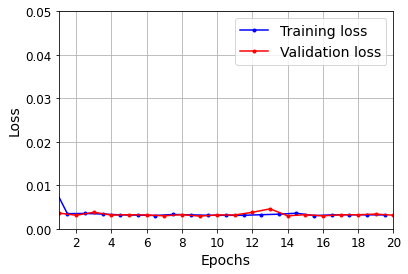

In [25]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

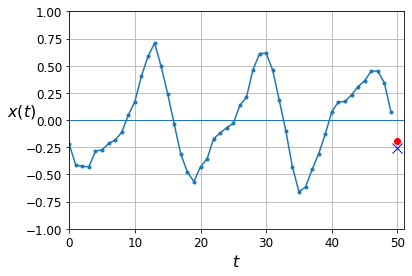

In [26]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forcasting Several Time Steps Ahead

In [27]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    print("X.shape = %s" % str(X.shape))
    print("y_pred_one.shape = %s" % str(y_pred_one.shape))
    X = np.concatenate([X, y_pred_one], axis=1)
    
Y_pred = X[:, n_steps:]

X.shape = (1, 50, 1)
y_pred_one.shape = (1, 1, 1)
X.shape = (1, 51, 1)
y_pred_one.shape = (1, 1, 1)
X.shape = (1, 52, 1)
y_pred_one.shape = (1, 1, 1)
X.shape = (1, 53, 1)
y_pred_one.shape = (1, 1, 1)
X.shape = (1, 54, 1)
y_pred_one.shape = (1, 1, 1)
X.shape = (1, 55, 1)
y_pred_one.shape = (1, 1, 1)
X.shape = (1, 56, 1)
y_pred_one.shape = (1, 1, 1)
X.shape = (1, 57, 1)
y_pred_one.shape = (1, 1, 1)
X.shape = (1, 58, 1)
y_pred_one.shape = (1, 1, 1)
X.shape = (1, 59, 1)
y_pred_one.shape = (1, 1, 1)


In [28]:
Y_pred.shape

(1, 10, 1)

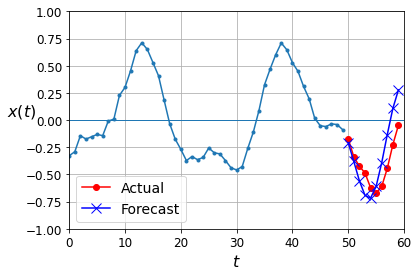

In [29]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
# save_fig("forecast_ahead_plot")
plt.show()

Predict all 10 next values at once

In [30]:
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [31]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [32]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 60s 255ms/step - loss: 0.0621 - val_loss: 0.0326
Epoch 2/20
219/219 [==============================] - 57s 258ms/step - loss: 0.0231 - val_loss: 0.0233
Epoch 3/20
219/219 [==============================] - 56s 258ms/step - loss: 0.0165 - val_loss: 0.0159
Epoch 4/20
219/219 [==============================] - 65s 298ms/step - loss: 0.0147 - val_loss: 0.0133
Epoch 5/20
219/219 [==============================] - 69s 315ms/step - loss: 0.0132 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 67s 306ms/step - loss: 0.0124 - val_loss: 0.0128
Epoch 7/20
219/219 [==============================] - 59s 267ms/step - loss: 0.0117 - val_loss: 0.0116
Epoch 8/20
219/219 [==============================] - 61s 278ms/step - loss: 0.0109 - val_loss: 0.0100
Epoch 9/20
219/219 [==============================] - 57s 262ms/step - loss: 0.0106 - val_loss: 0.0099
Epoch 10/20
219/219 [==============================] - 55s 251ms/step - l

In [33]:
# np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

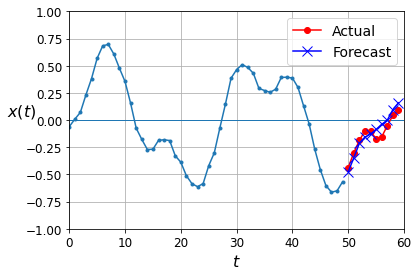

In [34]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

**Sequence-to-sequence RNN**

In [35]:
Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vector
series = generate_time_series(10000, n_steps + 10)
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead-1] = series[:, step_ahead:(step_ahead+n_steps), 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [36]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [37]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [38]:
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

/home/benson516/ml/my_env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [39]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 101s 428ms/step - loss: 0.1487 - last_time_step_mse: 0.1473 - val_loss: 0.1462 - val_last_time_step_mse: 0.1432
Epoch 2/20
219/219 [==============================] - 66s 302ms/step - loss: 0.1458 - last_time_step_mse: 0.1444 - val_loss: 0.1462 - val_last_time_step_mse: 0.1433
Epoch 3/20
219/219 [==============================] - 65s 297ms/step - loss: 0.1458 - last_time_step_mse: 0.1444 - val_loss: 0.1461 - val_last_time_step_mse: 0.1431
Epoch 4/20
219/219 [==============================] - 63s 290ms/step - loss: 0.1458 - last_time_step_mse: 0.1443 - val_loss: 0.1462 - val_last_time_step_mse: 0.1438
Epoch 5/20
219/219 [==============================] - 66s 303ms/step - loss: 0.1458 - last_time_step_mse: 0.1444 - val_loss: 0.1461 - val_last_time_step_mse: 0.1434
Epoch 6/20
219/219 [==============================] - 62s 284ms/step - loss: 0.1458 - last_time_step_mse: 0.1443 - val_loss: 0.1461 - val_last_time_step_mse: 0.1436
Epoch 7/2

In [40]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

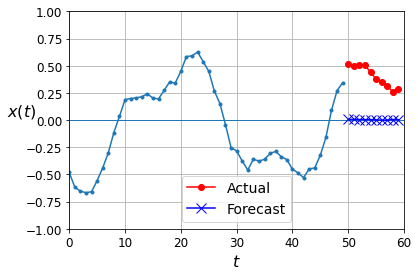

In [41]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Handling Long Sequences
## Fighting the Unstable Gradients Problem

In [42]:
# Custom memory cell
class LMSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
        
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [43]:
model = keras.models.Sequential([
    keras.layers.RNN(LMSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LMSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

## Tackling the Short-Term Memory Problem

In [44]:
# Use LSTM layer
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [45]:
# Use LSTMCell
model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

## Using 1D convolution layers to process sequences (as well as GRU)

In [46]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [47]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 70s 267ms/step - loss: 0.1459 - last_time_step_mse: 0.1445 - val_loss: 0.1462 - val_last_time_step_mse: 0.1433
Epoch 2/20
219/219 [==============================] - 75s 342ms/step - loss: 0.1458 - last_time_step_mse: 0.1444 - val_loss: 0.1462 - val_last_time_step_mse: 0.1433
Epoch 3/20
219/219 [==============================] - 72s 331ms/step - loss: 0.1457 - last_time_step_mse: 0.1444 - val_loss: 0.1462 - val_last_time_step_mse: 0.1433
Epoch 4/20
219/219 [==============================] - 124s 570ms/step - loss: 0.1457 - last_time_step_mse: 0.1444 - val_loss: 0.1462 - val_last_time_step_mse: 0.1436
Epoch 5/20
219/219 [==============================] - 119s 544ms/step - loss: 0.1457 - last_time_step_mse: 0.1444 - val_loss: 0.1462 - val_last_time_step_mse: 0.1435
Epoch 6/20
219/219 [==============================] - 165s 749ms/step - loss: 0.1457 - last_time_step_mse: 0.1444 - val_loss: 0.1462 - val_last_time_step_mse: 0.1434
Epoch 7

## WaveNet

In [48]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

In [49]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 23s 98ms/step - loss: 0.1457 - last_time_step_mse: 0.1444 - val_loss: 0.1460 - val_last_time_step_mse: 0.1433
Epoch 2/20
219/219 [==============================] - 23s 103ms/step - loss: 0.1457 - last_time_step_mse: 0.1444 - val_loss: 0.1460 - val_last_time_step_mse: 0.1434
Epoch 3/20
219/219 [==============================] - 24s 108ms/step - loss: 0.1457 - last_time_step_mse: 0.1444 - val_loss: 0.1460 - val_last_time_step_mse: 0.1433
Epoch 4/20
219/219 [==============================] - 22s 99ms/step - loss: 0.1457 - last_time_step_mse: 0.1444 - val_loss: 0.1461 - val_last_time_step_mse: 0.1435
Epoch 5/20
219/219 [==============================] - 23s 104ms/step - loss: 0.1457 - last_time_step_mse: 0.1443 - val_loss: 0.1461 - val_last_time_step_mse: 0.1435
Epoch 6/20
219/219 [==============================] - 25s 113ms/step - loss: 0.1457 - last_time_step_mse: 0.1444 - val_loss: 0.1460 - val_last_time_step_mse: 0.1434
Epoch 7/20
2